In [1]:
import os
os.chdir('/Users/alexrotondo/nlp/')

In [2]:
from stopwords import get_stopwords
from embeddings.utils.preprocessing.string_preprocessing import lower_text, remove_punctuation, tokenize_document
from embeddings.utils.document_config import DocumentConfig
from embeddings.utils.preprocessing.token_preprocessing import remove_stopwords, remove_unknown_words
from embeddings.utils.vocab_config import CorpusVocabConfig
from embeddings.utils.vocab import CorpusVocab

In [3]:
import numpy as np
import pandas as pd
import torch

In [4]:
import seaborn as sb
import matplotlib.pyplot as plt
sb.set_style('darkgrid')

In [5]:
million_songs = pd.read_csv('embeddings/data/spotify_millsongdata.csv')
million_songs.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,"Look at her face, it's a wonderful face \nAnd..."
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,"Take it easy with me, please \nTouch me gentl..."
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,I'll never know why I had to go \nWhy I had t...
3,ABBA,Bang,/a/abba/bang_20598415.html,Making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,Making somebody happy is a question of give an...


In [6]:
TOTAL_DOCUMENTS = million_songs.shape[0]

In [7]:
def remove_newline(text):
    return text.replace("\n", "")

million_songs.text = million_songs.text.apply(remove_newline)
million_songs.text = million_songs.text.apply(lower_text)
million_songs.text = million_songs.text.apply(remove_punctuation)
million_songs.head()

,artist,song,link,text
0,ABBA,Ahe's My Kind Of Girl,/a/abba/ahes+my+kind+of+girl_20598417.html,look at her face its a wonderful face and it ...
1,ABBA,"Andante, Andante",/a/abba/andante+andante_20002708.html,take it easy with me please touch me gently l...
2,ABBA,As Good As New,/a/abba/as+good+as+new_20003033.html,ill never know why i had to go why i had to p...
3,ABBA,Bang,/a/abba/bang_20598415.html,making somebody happy is a question of give an...
4,ABBA,Bang-A-Boomerang,/a/abba/bang+a+boomerang_20002668.html,making somebody happy is a question of give an...


In [8]:
million_songs['tokens'] = million_songs.text.apply(tokenize_document)
million_songs['n_tokens'] = million_songs.tokens.apply(len)

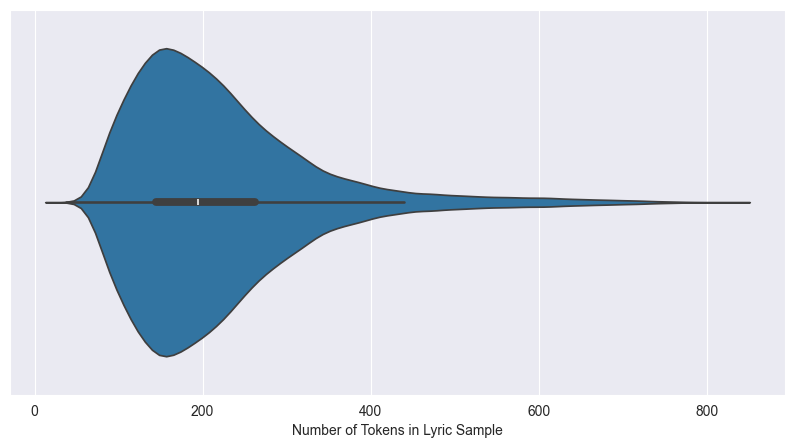

In [9]:
plt.figure(figsize=(10, 5))
sb.violinplot(data=million_songs, x='n_tokens')
plt.xlabel("Number of Tokens in Lyric Sample")
plt.show()

In [148]:
MAX_VOCAB_WORDS = 4000

vocab_config = CorpusVocabConfig(
    max_tokens=MAX_VOCAB_WORDS,
    randomize_token_index=False
)

document_config = DocumentConfig.create(
    lower_text=False, #already done
    exclude_punctuation=False, #already done
    remove_stopwords=True,
    excluded_punctuation=None,
    stopwords=None,
)

In [149]:
song_lyrics: list[str] = million_songs.text.to_list()

In [150]:
vocab: CorpusVocab = CorpusVocab.create(
    documents=song_lyrics,
    document_config=document_config,
    corpus_vocab_config=vocab_config
)

In [151]:
assert vocab.vocab_size == MAX_VOCAB_WORDS + 1

### Split Each Document into Tokens

In [152]:
song_lyric_tokens: list[list[str]] = million_songs.tokens.to_list()

### Remove Stopwords

In [153]:
STOPWORDS = get_stopwords()

def _remove_stopwords(x, stopwords=STOPWORDS):
    return remove_stopwords(document_tokens=x, stopwords=stopwords)

song_lyric_tokens: list = list(map(_remove_stopwords, song_lyric_tokens))

### Remove Unknown Words

In [154]:
def _remove_unknown_words(tokens: list[str], _vocab: CorpusVocab = vocab) -> list[str]:
    return remove_unknown_words(document_tokens=tokens,
                                vocab=_vocab.vocab,
                                unknown_word_identifier=_vocab.unknown_word_identifier)
song_lyric_tokens: list = list(map(_remove_unknown_words, song_lyric_tokens))

### Take only <em>n=256</em> tokens from each token sequence

In [155]:
song_lyric_tokens = [s[:256] for s in song_lyric_tokens]

### Map Tokens in Document to Identifiers

In [156]:
# create one-hot embeddings
bow_embeddings = []

for i, token_list in enumerate(song_lyric_tokens):
    encoding = [0] * len(token_list)
    for j, token in enumerate(token_list):
        encoding[j] = vocab.get_token_index(token=token)
    bow_embeddings.append(encoding)

In [157]:
print(np.array(bow_embeddings[0]))

[  80  180  823  180  962  133  964   80   36 2474 2109  574   11   19
    0   61   12  390   37  288   41  306   79   73  143   61   12  390
   37  158    2  125   79 1346   16  152 1876 2278    0  210   55   16
  405 1203  378  131 1531   61   12  390   37  288   41  306   79   73
  143   61   12  390   37  158    2  125   79 1346]


### Create Inputs: Context Window & Target Words

In [158]:
print(f"total documents: {TOTAL_DOCUMENTS}")

total documents: 57650


In [160]:
N_BATCHES = TOTAL_DOCUMENTS // 96
print(f"number of batches (size 256): {N_BATCHES}")

number of batches (size 256): 600


In [162]:
CONTEXT_WINDOW = 4
VOCAB_SIZE = vocab.vocab_size

X = []
y = []

for row in range(len(bow_embeddings)):
    _tokens = bow_embeddings[row]

    for index in range(len(_tokens) - CONTEXT_WINDOW * 2):
        _context_window_with_target = _tokens[index: index + (CONTEXT_WINDOW * 2) + 1]

        target = _context_window_with_target.pop(CONTEXT_WINDOW)
        context_window = _context_window_with_target

        y.append(target)
        X.append(context_window)

In [163]:
input = torch.tensor(X, dtype=torch.int64)
labels = torch.tensor(y, dtype=torch.int64)

In [164]:
labels[0]

tensor(962)

In [165]:
input.size()

torch.Size([6340059, 8])

In [166]:
labels.size()

torch.Size([6340059])

In [167]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [169]:
from embeddings.continuous_bag_of_words.model import ContinuousBagOfWords

model = ContinuousBagOfWords(
    vocab_size=vocab.vocab_size
)

In [170]:
input[0:2]

tensor([[  80,  180,  823,  180,  133,  964,   80,   36],
        [ 180,  823,  180,  962,  964,   80,   36, 2474]])

In [171]:
x = input[0:10]
model(x=x).size()

torch.Size([10, 4001])

In [172]:
BATCH_SIZE = 96
NUM_BATCHES = TOTAL_DOCUMENTS // BATCH_SIZE
NUM_EPOCHS = 5

In [173]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

# define loss function
loss_function = nn.CrossEntropyLoss()

# define optimizer
# -> include model parameters
# -> include base learning rate
optimizer = optim.Adam
optimizer = optimizer(model.parameters(), lr=0.025)

# define learning rate scheduler & function
# this function will linearly decrease the base learning rate to zero
# over the total number of epochs
lr_lambda = lambda _epoch: (NUM_EPOCHS - _epoch) / NUM_EPOCHS
lr_scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)


In [174]:
loss_by_epoch = []

for epoch in range(NUM_EPOCHS):
    running_loss = []

    for batch_index in range(NUM_BATCHES):
        starting_index = batch_index * BATCH_SIZE

        batch_input = input[starting_index: starting_index + BATCH_SIZE + 1]
        batch_labels = labels[starting_index: starting_index + BATCH_SIZE + 1]

        optimizer.zero_grad()
        forward_pass_results = model(batch_input)
        loss = loss_function(forward_pass_results, batch_labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

    loss_by_epoch.append(running_loss)

In [181]:
torch.save(model, 'embeddings/continuous_bag_of_words/model/cbow.pt')

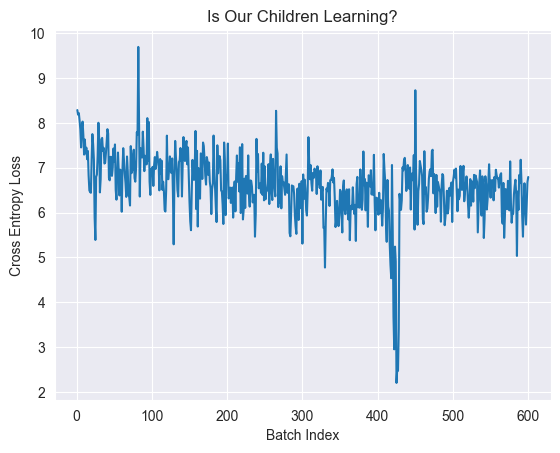

In [180]:
sb.lineplot(x=range(1, 1+NUM_BATCHES), y=loss_by_epoch[0], markers='o')
plt.title("Is Our Children Learning?")
plt.xlabel("Batch Index")
plt.ylabel("Cross Entropy Loss")
plt.show()

In [182]:
model = torch.load('embeddings/word2vec/model/cbow.pt')